Lets try and create a basic gflownet using a simple environment.
Base it off here: https://github.com/GFNOrg/torchgfn/blob/master/tutorials/notebooks/intro_gfn_smiley.ipynb

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import random

from torch.distributions.categorical import Categorical
import torch
import torch.nn as nn
from tqdm import tqdm, trange

In [2]:
torch.arange(2)

tensor([0, 1])

In [ ]:
## our dummy environment will be 'onlyOne'
## input is a 1X3 array of 0s. Actions are to flip an entry to 1
## goal is to have only one 1 in the array. reward is 1 if achieved, 0 otherwise

In [172]:
class GFlowNet(nn.Module):
    def __init__(self, num_hid):
        ## TODO: may need to change input/output dims
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3, num_hid),
            nn.LeakyReLU(),
            nn.Linear(num_hid, 3)
        )
    
    def forward(self, x):
        return self.mlp(x).exp()

class replayBuffer:

    def __init__(self):
        ## should I include initial state?
        self.states = []
        self.actions = []

    def insert(self, state, action):
        self.states.append(state)
        self.actions.append(action)

    def get_parents(self, state):
        prev_states = torch.tensor(self.states)

        ## for OnlyOne parents are where there is only a difference of 1
        parent_idx = torch.where(
            torch.abs(
                torch.tensor(state).sum() - prev_states.sum(axis=1)
            ) == 1
        )

        parent_states = prev_states[parent_idx]

        # parent actions are the bit flipped to get from previous state to this state
        parent_actions = torch.where(parent_states != torch.tensor(state))[1]

        return parent_states, parent_actions
    
    def reset(self):
        self.states = []
        self.actions = []


def flow_matching_loss(incoming_flows, outgoing_flows, reward):
    return (incoming_flows.sum() - outgoing_flows.sum() - reward).pow(2)

def flip(x):
    return x + (-1)**x

def update_state(state, action):
    state[action] = flip(state[action])
    return state

def calc_reward(final_state):
    return int(sum(final_state)==1)


def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [214]:
## run it:

## set the seed
set_seed(42)

## create the network
device='cpu'
gflownet = GFlowNet(10)
opt = torch.optim.Adam(gflownet.parameters(), 1e-4)
buffer = replayBuffer()

losses, samples = [], []
minibatch_loss = 0
update_freq = 10
T = 5
n_episodes = 320
tbar = trange(n_episodes, desc="Training iter")
for episode in tbar:

    state = [0,0,0] 
    edge_flow_preds = net(torch.tensor(state).float()) # should convert state to tensor

    ## this is the length of the trajectory
    for t in range(T):

        ## normalise to get probs
        policy = edge_flow_preds / edge_flow_preds.sum()

        ## select discrete action
        action = Categorical(probs=policy).sample()

        ## TODO: here we need to update the environment based on the action
        buffer.insert(state, action)
        new_state = update_state(state.copy(), action)
        # print(state, new_state, buffer.states)
        
        # calc flows
        parent_states, parent_actions = buffer.get_parents(new_state)
        print(f"current state: {new_state}",f"parent states: {parent_states};\n parent actions: {parent_actions}", sep='\n==============\n')
        ps = torch.stack([p for p in parent_states]).float()
        pa = torch.tensor(parent_actions).long()
        # takes relevant flows for action given state
        parent_edge_flow_preds = net(ps)[torch.arange(len(parent_states)), pa]

        ## end of trajectory
        if t==(T-1):
            reward = calc_reward(new_state) 
            edge_flow_preds = torch.zeros(3) ## need to change value?
        else:
            reward = 0
            edge_flow_preds = net(torch.tensor(new_state).float())

        minibatch_loss += flow_matching_loss(
            parent_edge_flow_preds,
            edge_flow_preds,
            reward
        )
        state = new_state

    ## clear buffer between episodes
    buffer.reset()

    ## record final state:
    samples.append(state)

    ## gradient step / parameter update
    if episode % update_freq == 0:

        # normalise loss
        minibatch_loss = minibatch_loss / update_freq
        losses.append(minibatch_loss.item())
        tbar.set_description(f"Training iter {episode} (loss={minibatch_loss:.6f})")
        minibatch_loss.backward()
        opt.step()
        opt.zero_grad()
        minibatch_loss=0
        

Training iter:   0%|          | 0/320 [00:00<?, ?it/s]C:\Users\61417\AppData\Local\Temp\ipykernel_40836\4054840310.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pa = torch.tensor(parent_actions).long()
Training iter 0 (loss=2.413908):   0%|          | 1/320 [00:00<00:05, 62.09it/s]

current state: [0, 1, 0]
parent states: tensor([[0, 0, 0]]);
 parent actions: tensor([1])
current state: [0, 0, 0]
parent states: tensor([[0, 1, 0]]);
 parent actions: tensor([1])
current state: [0, 0, 1]
parent states: tensor([[0, 0, 0],
        [0, 0, 0]]);
 parent actions: tensor([2, 2])
current state: [0, 1, 1]
parent states: tensor([[0, 1, 0],
        [0, 0, 1]]);
 parent actions: tensor([2, 1])
current state: [0, 1, 0]
parent states: tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 1, 1]]);
 parent actions: tensor([1, 1, 2])
current state: [1, 0, 0]
parent states: tensor([[0, 0, 0]]);
 parent actions: tensor([0])
current state: [1, 1, 0]
parent states: tensor([[1, 0, 0]]);
 parent actions: tensor([1])
current state: [1, 0, 0]
parent states: tensor([[0, 0, 0],
        [1, 1, 0]]);
 parent actions: tensor([0, 1])
current state: [1, 0, 1]
parent states: tensor([[1, 0, 0],
        [1, 0, 0]]);
 parent actions: tensor([2, 2])
current state: [0, 0, 1]
parent states: tensor([[0, 0, 0],

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [3], [5]

In [213]:
buffer.states

[[0, 0, 0], [1, 0, 0], [1, 1, 0], [1, 0, 0], [1, 0, 1]]

In [204]:
torch.where(parent_states != torch.tensor(state))[1]

tensor([0, 2, 1, 2])

In [209]:
prev_states = torch.tensor(buffer.states)

## for OnlyOne parents are where there is only a difference of 1
parent_idx = torch.where(
    torch.abs(
        torch.tensor(state).sum() - prev_states.sum(axis=1)
    ) == 1
)

parent_states = prev_states[parent_idx]

# parent actions are the bit flipped to get from previous state to this state
parent_actions = torch.where(parent_states != torch.tensor(state))[1]

parent_states, parent_actions

(tensor([[1, 0, 0],
         [1, 0, 0]]),
 tensor([2, 2]))

In [205]:
parent_states

tensor([[0, 0, 0],
        [1, 1, 0],
        [1, 0, 1]])

In [206]:
state

[1, 0, 1]

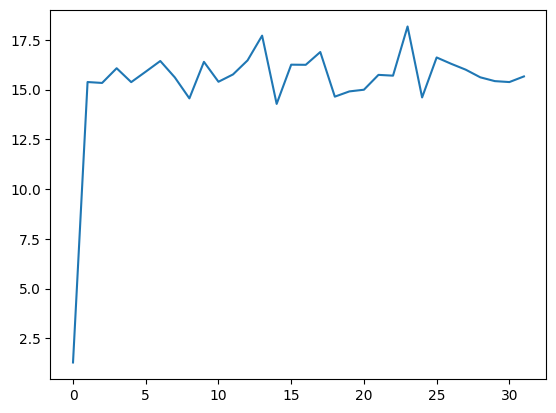

In [198]:
plt.plot(losses)

In [199]:
((torch.tensor(samples).sum(axis=1) == 1).float()).mean()

tensor(0.7781)

In [153]:
net()

[0, 1, 0]

In [145]:
update_state(state, action)

In [143]:
print(state, action)
state[action]=flip(state[action])
state

[0, 1, 0] tensor(1)


[0, 0, 0]

In [76]:


_mouth_kwargs = {"closed": False, "fill": False, "lw": 3}
FEATURES = {
    'smile': lambda: plt.gca().add_patch(plt.Polygon(
        np.stack(
            [np.linspace(0.2, 0.8), 0.3 - np.sin(np.linspace(0, 3.14)) * 0.15]
        ).T,
        **_mouth_kwargs
        )
    ),
    'frown': lambda: plt.gca().add_patch(plt.Polygon(
        np.stack(
            [np.linspace(0.2, 0.8), 0.15 + np.sin(np.linspace(0, 3.14)) * 0.15]
        ).T,
        **_mouth_kwargs,
        )
    ),
    'left_eb_down': lambda: plt.gca().add_line(plt.Line2D(
        [0.15, 0.35], [0.75, 0.7], color=(0, 0, 0))
    ),
    'right_eb_down': lambda: plt.gca().add_line(plt.Line2D(
        [0.65, 0.85], [0.7, 0.75], color=(0, 0, 0))
    ),
    'left_eb_up': lambda: plt.gca().add_line(plt.Line2D(
        [0.15, 0.35], [0.7, 0.75], color=(0, 0, 0))
    ),
    'right_eb_up': lambda: plt.gca().add_line(plt.Line2D(
        [0.65, 0.85], [0.75, 0.7], color=(0, 0, 0))
    ),
}
# Our feature space. A face has one mouth, one left eyebrow, and one right eyebrow.
MOUTHS = ["smile", "frown"]
LEFT_EB = ["left_eb_down", "left_eb_up"]
RIGHT_EB = ["right_eb_down", "right_eb_up"]
FEATURE_KEYS = MOUTHS + LEFT_EB + RIGHT_EB
print("FEATURE_KEYS={}".format(FEATURE_KEYS))

def face_parents(state):
  parent_states = []  # States that are parents of state.
  parent_actions = []  # Actions that lead from those parents to state.

  for feature in state:
    # For each face part, there is a parent without that part.
    parent_states.append([i for i in state if i != feature])  # TODO: implement.

    # The action to get there is the corresponding index of that face part.
    parent_actions.append(FEATURE_KEYS.index(feature))  # TODO: implement.

  return parent_states, parent_actions

state = []
new_state = state + [FEATURE_KEYS[1]] # frown
print(face_parents(new_state))
new_state = new_state + [FEATURE_KEYS[3]] # left_eb_up
print(face_parents(new_state))
new_state = new_state + [FEATURE_KEYS[-1]] # right_eb_up
print(face_parents(new_state))
new_state = new_state + [FEATURE_KEYS[2]] # right_eb_up
print(face_parents(new_state))



FEATURE_KEYS=['smile', 'frown', 'left_eb_down', 'left_eb_up', 'right_eb_down', 'right_eb_up']
([[]], [1])
([['left_eb_up'], ['frown']], [1, 3])
([['left_eb_up', 'right_eb_up'], ['frown', 'right_eb_up'], ['frown', 'left_eb_up']], [1, 3, 5])
([['left_eb_up', 'right_eb_up', 'left_eb_down'], ['frown', 'right_eb_up', 'left_eb_down'], ['frown', 'left_eb_up', 'left_eb_down'], ['frown', 'left_eb_up', 'right_eb_up']], [1, 3, 5, 2])


In [85]:
next_state = torch.tensor([1,1,0])
prev_states = torch.tensor([
    [0,0,0],
    [0,1,0],
    [1,1,0],
    [0,1,0],
    [1,1,0],
    [1,1,1]
])


parents = torch.where(torch.abs(next_state.sum() - prev_states.sum(axis=1)) ==1)

parent_states = prev_states[parents]

parent_actions = torch.where(parent_states != next_state)[1]

print(next_state, parent_states, parent_actions, sep='\n')

tensor([1, 1, 0])
tensor([[0, 1, 0],
        [0, 1, 0],
        [1, 1, 1]])
tensor([0, 0, 2])


tensor([1, 1, 0])
tensor([[0, 1, 0],
        [0, 1, 0]])
tensor([0, 0])


In [66]:
# parents in OnlyOne have only 1 value different
# so a possible parent of a state is
def get_parent_state(next_state, states):
    
